In [25]:
import mat73
import pandas as pd
import numpy as np
import scipy.io
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading and preprocessing

In [26]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()) and "anuja" in os.environ.get('USER'):
    DATA_DIR = 'data/'
    

In [27]:
foof = pd.read_csv(DATA_DIR+"foof2features_source.csv")
foof = foof.drop('Unnamed: 0', 1)
foof

/tmp/ipykernel_1104738/2273453860.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  foof = foof.drop('Unnamed: 0', 1)


,IDs,Intercept,Slope
0,NDARAA075AMK,0.282555,1.441946
1,NDARAA112DMH,1.372408,1.505823
2,NDARAA117NEJ,1.182087,1.395998
3,NDARAA947ZG5,0.401675,1.222953
4,NDARAA948VFH,-0.033039,1.318181
...,...,...,...
2037,NDARZN277NR6,-0.418218,1.085482
2038,NDARZN578YDP,1.587596,1.466845
2039,NDARZN610GTY,-0.656477,1.232983
2040,NDARZN677EYE,0.414824,1.251458


In [28]:
data = mat73.loadmat(DATA_DIR+'x_source_new.mat')  
df2 = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))

# sparsing
df2 = np.array(df2).reshape(data['x'].shape) 
df2_sparsed = np.concatenate([np.expand_dims(df2[:,:,i:i+2].mean(axis = 2), axis = 2) for i in range(0, data['x'].shape[2]-2, 2)], axis = 2)
df2 = pd.DataFrame(df2_sparsed.reshape((df2_sparsed.shape[0], -1)))

#scaling
norm = MinMaxScaler().fit(df2)
df2 = norm.transform(df2)
df2 = pd.DataFrame(df2.reshape((df2.shape[0], -1)))

df2['IDs'] = foof['IDs']
df2

,0,1,2,3,4,5,6,7,8,9,...,2643,2644,2645,2646,2647,2648,2649,2650,2651,IDs
0,5.101913e-11,1.992207e-08,2.402816e-06,1.218602e-04,3.864207e-03,0.040095,0.179954,4.270175e-01,4.634880e-01,3.890722e-01,...,3.843416e-03,2.106884e-04,5.118096e-06,4.670563e-08,1.832631e-10,3.079021e-13,1.701302e-16,0.000000e+00,0.000000e+00,NDARAA075AMK
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,6.776939e-17,5.105700e-16,5.725257e-15,...,2.088142e-01,2.313505e-01,4.140847e-01,2.058921e-01,3.437418e-01,1.930270e-01,2.860178e-01,4.766788e-02,7.230240e-04,NDARAA112DMH
2,2.661419e-02,1.264720e-01,8.284766e-06,2.918035e-12,3.280463e-09,0.000007,0.038736,1.984120e-01,2.976885e-01,4.438104e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NDARAA117NEJ
3,2.380404e-02,4.203522e-01,3.468028e-01,3.200351e-01,4.774229e-01,0.074612,0.079222,1.015326e-01,9.357454e-02,1.306764e-01,...,1.911892e-01,6.062096e-02,4.113846e-01,7.161245e-01,3.323713e-01,5.250955e-02,1.845979e-01,4.270583e-01,1.610893e-01,NDARAA947ZG5
4,2.394631e-01,4.350986e-01,3.745264e-01,2.070651e-01,1.087368e-01,0.030269,0.095985,2.162397e-01,1.855508e-01,1.166599e-01,...,6.742616e-02,7.341512e-02,8.137233e-02,7.837132e-02,7.548040e-02,7.270647e-02,1.187193e-01,7.464320e-02,6.494024e-02,NDARAA948VFH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,3.739917e-03,1.621763e-01,1.145210e-01,1.717832e-03,2.876346e-03,0.036229,0.203065,2.488511e-01,1.714610e-01,8.331924e-02,...,1.686810e-03,1.423780e-04,1.267766e-05,1.576811e-06,2.304640e-07,3.126707e-08,3.797884e-09,4.119393e-10,3.989325e-11,NDARZN277NR6
2038,2.134005e-06,4.229760e-04,1.248026e-02,7.758914e-02,1.714416e-01,0.180892,0.169312,1.428294e-01,2.635778e-01,3.428152e-01,...,2.357898e-07,3.632691e-08,5.206799e-09,5.926503e-10,6.164682e-11,5.860062e-12,5.090295e-13,4.043299e-14,2.933030e-15,NDARZN578YDP
2039,5.561633e-16,1.265773e-12,8.057262e-10,1.905719e-07,2.488557e-05,0.000939,0.013563,9.140757e-02,1.911413e-01,2.630192e-01,...,7.135652e-02,9.507114e-02,1.348492e-01,1.594672e-01,1.807321e-01,1.963087e-01,2.043546e-01,2.038778e-01,1.949377e-01,NDARZN610GTY
2040,1.186254e-07,1.126116e-05,3.801973e-04,6.209405e-03,7.283916e-02,0.320383,0.696183,9.051547e-01,5.121514e-01,2.078802e-01,...,1.125051e-03,3.257921e-04,8.646941e-05,1.795490e-05,3.356598e-06,5.649386e-07,8.560071e-08,1.167659e-08,1.433856e-09,NDARZN677EYE


In [29]:
beh = pd.read_csv(DATA_DIR+"behaviorals.csv")
print('Before:'+str(beh.shape))

most_common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders',  'No Diagnosis Given', 'Other Disorders']

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] +\
                   ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

# removing patients with incomplete eval
initial_size = beh.shape[0]
beh = beh[beh.DX_01 != 'No Diagnosis Given: Incomplete Eval']
beh = beh.reset_index(drop=True)
new_size = beh.shape[0]

print('After:'+str(beh.shape))
print('Removing', initial_size - new_size,
      'patients as their evaluations was incomplete.')

Before:(3076, 177)
After:(2939, 177)
Removing 137 patients as their evaluations was incomplete.


In [30]:
no_diagnosis_given = 'No Diagnosis Given'

diagnoses_to_ids = {disorder: i for i, disorder in enumerate(most_common_disorders)}
diagnoses_to_ids

{'Attention-Deficit/Hyperactivity Disorder': 0,
 'Anxiety Disorders': 1,
 'Specific Learning Disorder': 2,
 'Autism Spectrum Disorder': 3,
 'Disruptive': 4,
 'Communication Disorder': 5,
 'Depressive Disorders': 6,
 'No Diagnosis Given': 7,
 'Other Disorders': 8}

In [31]:
def get_disorder(data, row, index):
    disorder = data.iloc[row][category_columns[index]]

    if disorder == 'Neurodevelopmental Disorders':
        disorder = data.iloc[row][category_columns[index + 10]]

    return disorder

order_of_disorders = []
for k in range(beh.shape[0]):
    i = 0
    disorder = get_disorder(beh, k, i)
    disorders_patient = []
    while not pd.isnull(disorder):
        if disorder in diagnoses_to_ids:
            if diagnoses_to_ids[disorder] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids[disorder])
        else:
            if diagnoses_to_ids['Other Disorders'] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids['Other Disorders'])
        i += 1
        if i == len(category_columns):
            break
        disorder = get_disorder(beh, k, i)

        
    order_of_disorders.append(disorders_patient)

In [32]:
other_disorders = []
no_diagnosis_given = []
for i in order_of_disorders:
    if 7 in i:
        no_diagnosis_given.append(1)
        i.remove(7)
    else:
        no_diagnosis_given.append(0)
    if 8 in i:
        other_disorders.append(1)
        i.remove(8)
    else:
        other_disorders.append(0)

In [33]:
max_len_order = np.max([len(x) for x in order_of_disorders])

# pad with a new token denoting the pad token
pad_token = len(most_common_disorders)
bod_token = len(most_common_disorders) + 1
eod_token = len(most_common_disorders) + 2

order_of_disorders = [[bod_token] + x + [eod_token] + [pad_token] * (max_len_order - len(x)) for x in order_of_disorders]

order_of_disorders = np.array(order_of_disorders)

classes = np.zeros((len(most_common_disorders),
                    beh.shape[0]), dtype=np.int32)

df_disorders = beh[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
        applymap(lambda x: disorder in x if pd.notnull(x) else False)

    disorder_df = df_disorders[mask.any(axis=1)]

    np.add.at(classes[i], disorder_df.index.values, 1)

behaviour_data_columns = beh.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

behaviour_data = beh.drop(columns=columns_to_drop)

for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

behaviour_data['order_diagnoses'] = list(order_of_disorders)

In [34]:
common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders']

labels=behaviour_data[["IDs"]+list(common_disorders)]
labels["Other Disorders"] = other_disorders
labels

/tmp/ipykernel_1104738/226828375.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels["Other Disorders"] = other_disorders


,IDs,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders,Other Disorders
0,NDARAA075AMK,0,0,0,0,0,0,0,0
1,NDARAA112DMH,1,0,0,0,1,0,0,1
2,NDARAA117NEJ,1,0,0,0,1,0,0,1
3,NDARAA306NT2,1,1,1,0,0,1,0,1
4,NDARAA504CRN,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
2934,NDARZZ007YMP,0,0,0,1,0,0,0,1
2935,NDARZZ740MLM,1,0,0,0,0,0,0,0
2936,NDARZZ810LVF,0,0,0,1,0,1,0,1
2937,NDARZZ830JM7,0,0,0,1,0,0,0,1


In [35]:
df = pd.merge(df2, foof, on='IDs', how='inner')
df = pd.merge(df2, labels, on='IDs', how='inner')
df

,0,1,2,3,4,5,6,7,8,9,...,2651,IDs,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders,Other Disorders
0,5.101913e-11,1.992207e-08,2.402816e-06,1.218602e-04,3.864207e-03,0.040095,0.179954,4.270175e-01,4.634880e-01,3.890722e-01,...,0.000000e+00,NDARAA075AMK,0,0,0,0,0,0,0,0
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,6.776939e-17,5.105700e-16,5.725257e-15,...,7.230240e-04,NDARAA112DMH,1,0,0,0,1,0,0,1
2,2.661419e-02,1.264720e-01,8.284766e-06,2.918035e-12,3.280463e-09,0.000007,0.038736,1.984120e-01,2.976885e-01,4.438104e-01,...,0.000000e+00,NDARAA117NEJ,1,0,0,0,1,0,0,1
3,2.380404e-02,4.203522e-01,3.468028e-01,3.200351e-01,4.774229e-01,0.074612,0.079222,1.015326e-01,9.357454e-02,1.306764e-01,...,1.610893e-01,NDARAA947ZG5,1,0,1,1,0,0,0,1
4,2.394631e-01,4.350986e-01,3.745264e-01,2.070651e-01,1.087368e-01,0.030269,0.095985,2.162397e-01,1.855508e-01,1.166599e-01,...,6.494024e-02,NDARAA948VFH,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,5.687962e-13,7.427652e-10,2.468634e-07,2.845926e-05,1.696065e-03,0.027454,0.160432,4.150554e-01,4.015172e-01,6.698752e-01,...,1.641399e-01,NDARZN148PMN,0,1,0,0,0,0,0,0
1917,3.739917e-03,1.621763e-01,1.145210e-01,1.717832e-03,2.876346e-03,0.036229,0.203065,2.488511e-01,1.714610e-01,8.331924e-02,...,3.989325e-11,NDARZN277NR6,1,1,0,0,0,0,1,0
1918,5.561633e-16,1.265773e-12,8.057262e-10,1.905719e-07,2.488557e-05,0.000939,0.013563,9.140757e-02,1.911413e-01,2.630192e-01,...,1.949377e-01,NDARZN610GTY,0,0,0,0,0,0,0,1
1919,1.186254e-07,1.126116e-05,3.801973e-04,6.209405e-03,7.283916e-02,0.320383,0.696183,9.051547e-01,5.121514e-01,2.078802e-01,...,1.433856e-09,NDARZN677EYE,1,0,0,0,0,0,0,0


### Data Split

In [36]:
disorders_list = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders', 'Other Disorders']
x = df[df.columns.difference(['IDs']+disorders_list)]
y = df[disorders_list]

# summarize dataset shape
print(x.shape, y.shape)

(1921, 2652) (1921, 8)


In [37]:
train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size=0.25, shuffle=True)

In [38]:
train_labels = np. array(train_labels) 
test_labels = np. array(test_labels) 

In [39]:
print(train_features.shape, test_features.shape)

(1440, 2652) (481, 2652)


## FEATURE EXTRACTION WITH PCA

In [40]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(1440, 2652) (481, 2652)


In [41]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features)

# transform data
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print(train_features.shape, test_features.shape)

(1440, 416) (481, 416)


In [42]:
train_labels.sum(axis=0)

array([876, 463, 325, 210, 223, 204, 140, 553])

In [43]:
test_labels.sum(axis=0)

array([290, 177, 114,  82,  74,  68,  54, 204])

## FEATURE EXTRACTION WITH AUTOENCODER

In [44]:
# import tensorflow as tf
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
# from tensorflow.keras.utils import plot_model, to_categorical

# n_inputs = train_features.shape[1]

# visible = Input(shape=(n_inputs,))
# e = Dense(n_inputs*2)(visible)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# e = Dense(n_inputs)(e)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# n_bottleneck = round(float(n_inputs) / 2.0)
# bottleneck = Dense(n_bottleneck)(e)

# d = Dense(n_inputs)(bottleneck)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# d = Dense(n_inputs*2)(d)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# output = Dense(8, activation='linear')(d)

# model = Model(inputs=visible, outputs=output)
# model.compile(optimizer='adam', loss='mse')
# plot_model(model, 'autoencoder_compress.png', show_shapes=True)

# history = model.fit(train_features, train_labels, epochs=50, batch_size=16, verbose=2)
# encoder = Model(inputs=visible, outputs=bottleneck)

# plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# encoder.save('autoencoder.h5')

In [45]:
# # encode the data
# encoder= load_model('autoencoder.h5', compile=False)

# train_features = encoder.predict(train_features)
# test_features = encoder.predict(test_features)

### Metrics

In [46]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
    average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")

    plt.show()
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [47]:
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Hamming Loss:", hamming_loss(y_test, y_pred))
    if brier:
        print("Brier Score:", brier_multi(y_test, y_pred_prob))
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))

## Models

### Multi Output Classifier

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

LogisticRegression():
Accuracy: 0.06652806652806653
Hamming Loss: 0.2933991683991684
Brier Score: 1.637791695834133
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.69      0.65       290
           1       0.37      0.25      0.30       177
           2       0.18      0.07      0.10       114
           3       0.22      0.06      0.10        82
           4       0.31      0.11      0.16        74
           5       0.10      0.03      0.05        68
           6       0.18      0.06      0.08        54
           7       0.38      0.22      0.28       204

   micro avg       0.45      0.30      0.36      1063
   macro avg       0.29      0.19      0.21      1063
weighted avg       0.37      0.30      0.32      1063
 samples avg       0.55      0.39      0.32      1063

Confusion matrix:
 [[[ 65 126]
  [ 90 200]]

 [[228  76]
  [133  44]]

 [[330  37]
  [106   8]]

 [[381  18]
  [ 77   5]]

 [[389  18]
  [ 66   8]]

 [[395

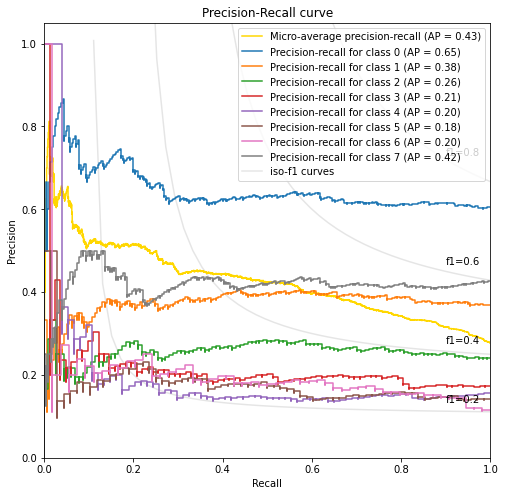

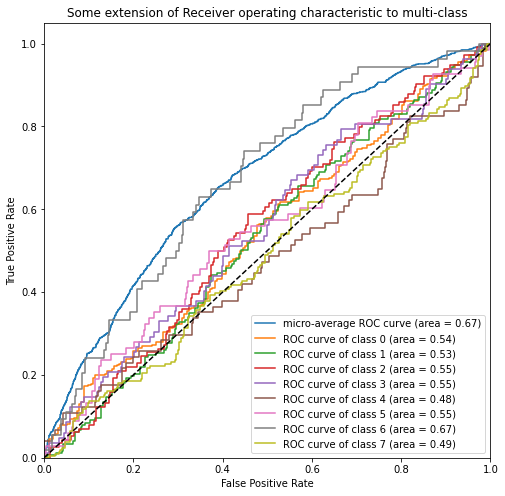

RandomForestClassifier(random_state=1):
Accuracy: 0.10395010395010396
Hamming Loss: 0.25727650727650725
Brier Score: 1.444365280665281
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.93      0.73       290
           1       0.50      0.01      0.01       177
           2       1.00      0.00      0.00       114
           3       0.00      0.00      0.00        82
           4       0.00      0.00      0.00        74
           5       0.50      0.01      0.03        68
           6       0.00      0.00      0.00        54
           7       0.24      0.02      0.04       204

   micro avg       0.58      0.26      0.36      1063
   macro avg       0.35      0.12      0.10      1063
weighted avg       0.43      0.26      0.21      1063
 samples avg       0.62      0.37      0.34      1063

Confusion matrix:
 [[[ 14 177]
  [ 20 270]]

 [[303   1]
  [176   1]]

 [[367   0]
  [114   0]]

 [[393   6]
  [ 82   0]]

 [[404   3]
 

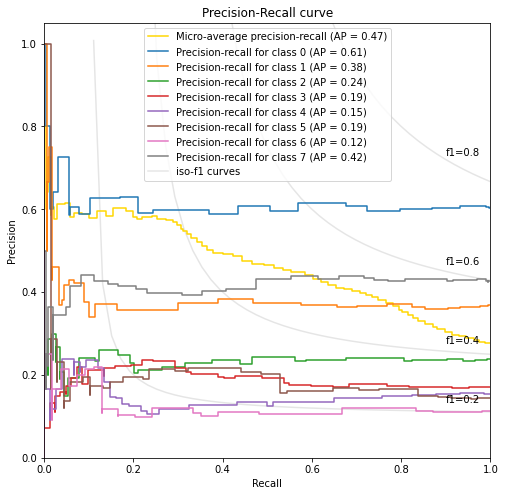

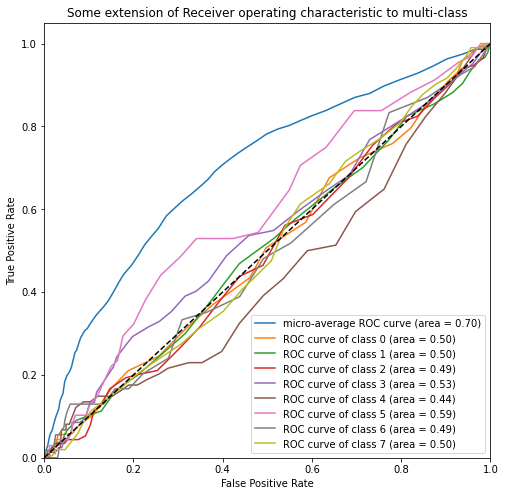

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
forest = RandomForestClassifier(random_state=1)
lg = LogisticRegression()
models = [lg, forest]

for model in models:

    multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
    multi_output_model.fit(train_features, train_labels)
    predicted_labels = np.asarray(multi_output_model.predict_proba(test_features))[:, :, 1].T
    print(str(model)+':')
    evaluate(test_labels, predicted_labels)
    plot_pr_curve(test_labels, predicted_labels)
    plot_roc_curve(test_labels, predicted_labels)

## MLP simple

2021-11-30 12:47:03.476491: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-30 12:47:03.503527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 12:47:03.504219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:06.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-11-30 12:47:03.504519: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-30 12:47:03.506117: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-30 12:47:03.508376: I tensorflow/stream_executor/platform/default/d

Epoch 1/100


2021-11-30 12:47:04.497904: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


45/45 [==============================] - 0s 1ms/step - loss: 0.6594
Epoch 2/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5409
Epoch 3/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4966
Epoch 4/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4738
Epoch 5/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4572
Epoch 6/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4424
Epoch 7/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4283
Epoch 8/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4138
Epoch 9/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3995
Epoch 10/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3853
Epoch 11/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3710
Epoch 12/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3568
Epoch 13/100
45/45 [=============================

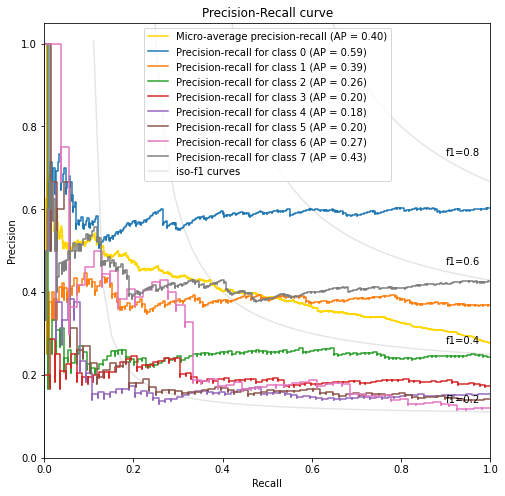

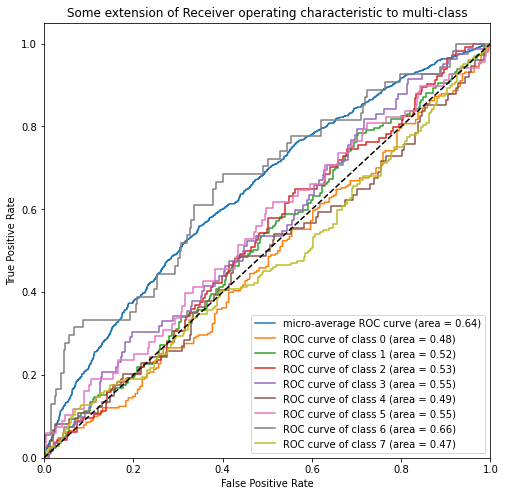

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
mlp = get_mlp(n_inputs, n_outputs)
mlp.fit(train_features, train_labels, verbose=1, epochs=100)

predicted_labels_mlp = mlp.predict(test_features)
evaluate(test_labels, predicted_labels_mlp)

plot_pr_curve(test_labels, predicted_labels_mlp)
plot_roc_curve(test_labels, predicted_labels_mlp)

## MLP complex

Epoch 1/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6275
Epoch 2/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5239
Epoch 3/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4975
Epoch 4/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4838
Epoch 5/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4711
Epoch 6/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4584
Epoch 7/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4438
Epoch 8/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4282
Epoch 9/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4109
Epoch 10/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3925
Epoch 11/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3726
Epoch 12/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3523
Epoch 13/100
45/45 [=================

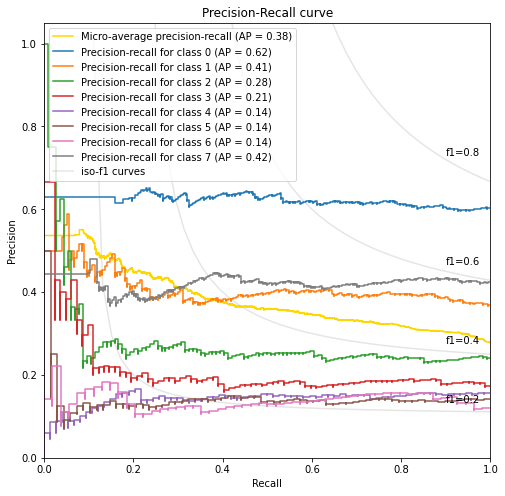

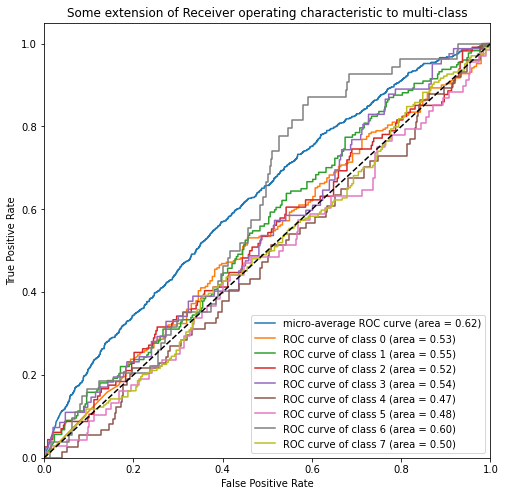

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
mlp = get_mlp(n_inputs, n_outputs)
mlp.fit(train_features, train_labels, verbose=1, epochs=100)

predicted_labels_mlp = mlp.predict(test_features)
evaluate(test_labels, predicted_labels_mlp)

plot_pr_curve(test_labels, predicted_labels_mlp)
plot_roc_curve(test_labels, predicted_labels_mlp)

### Binary Relevance
ignores the possible correlations between class labels

In [51]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

classifier = BinaryRelevance(GaussianNB())
classifier.fit(train_features, train_labels)

BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])

In [52]:
predicted_labels_br = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_br.toarray())

Accuracy: 0.033264033264033266
Hamming Loss: 0.3947505197505197
Brier Score: 2.7762468890435876
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.26      0.36       290
           1       0.38      0.71      0.50       177
           2       0.23      0.56      0.32       114
           3       0.25      0.17      0.20        82
           4       0.17      0.12      0.14        74
           5       0.06      0.03      0.04        68
           6       0.15      0.59      0.24        54
           7       0.46      0.19      0.27       204

   micro avg       0.31      0.34      0.32      1063
   macro avg       0.29      0.33      0.26      1063
weighted avg       0.38      0.34      0.31      1063
 samples avg       0.34      0.40      0.29      1063

Confusion matrix:
 [[[140  51]
  [214  76]]

 [[ 98 206]
  [ 51 126]]

 [[147 220]
  [ 50  64]]

 [[357  42]
  [ 68  14]]

 [[363  44]
  [ 65   9]]

 [[381  32]
  [ 66   2]]



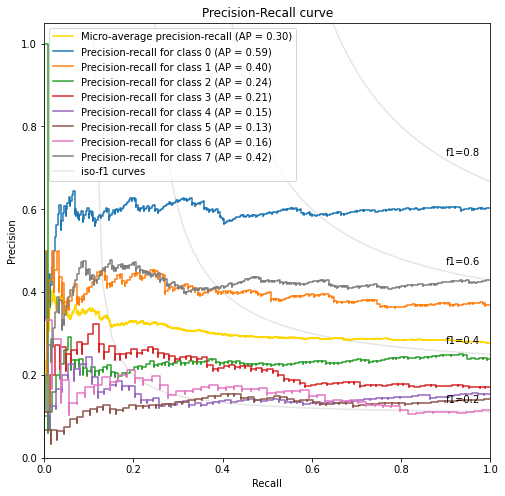

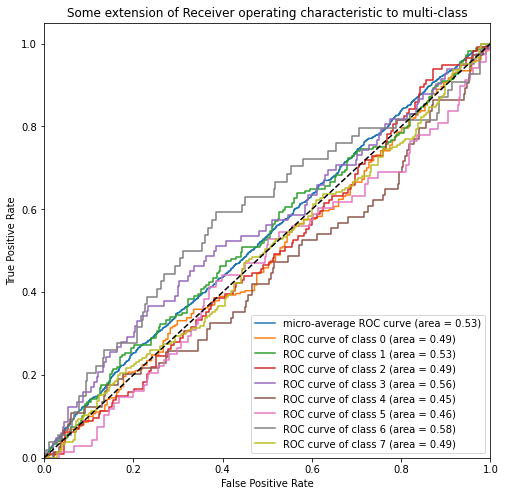

In [53]:
plot_pr_curve(test_labels, predicted_labels_br.toarray())
plot_roc_curve(test_labels, predicted_labels_br.toarray())

### Classfier Chains

In [54]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

classifier = ClassifierChain(LogisticRegression())
classifier.fit(train_features, train_labels)
# we should optimise this a little

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

ClassifierChain(classifier=LogisticRegression(), require_dense=[True, True])

In [55]:
predicted_labels_cc = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_cc.toarray())

Accuracy: 0.07692307692307693
Hamming Loss: 0.29313929313929316
Brier Score: 1.7031638492034513
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.69      0.65       290
           1       0.37      0.25      0.30       177
           2       0.20      0.08      0.11       114
           3       0.32      0.10      0.15        82
           4       0.24      0.16      0.19        74
           5       0.16      0.04      0.07        68
           6       0.30      0.13      0.18        54
           7       0.40      0.20      0.26       204

   micro avg       0.45      0.30      0.36      1063
   macro avg       0.32      0.21      0.24      1063
weighted avg       0.39      0.30      0.33      1063
 samples avg       0.57      0.39      0.32      1063

Confusion matrix:
 [[[ 65 126]
  [ 90 200]]

 [[227  77]
  [132  45]]

 [[330  37]
  [105   9]]

 [[382  17]
  [ 74   8]]

 [[368  39]
  [ 62  12]]

 [[397  16]
  [ 65   3]]



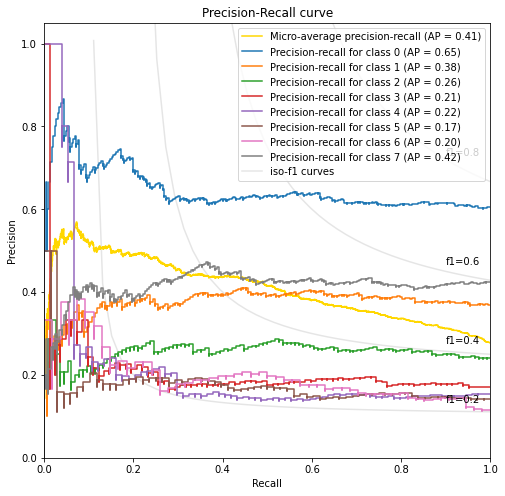

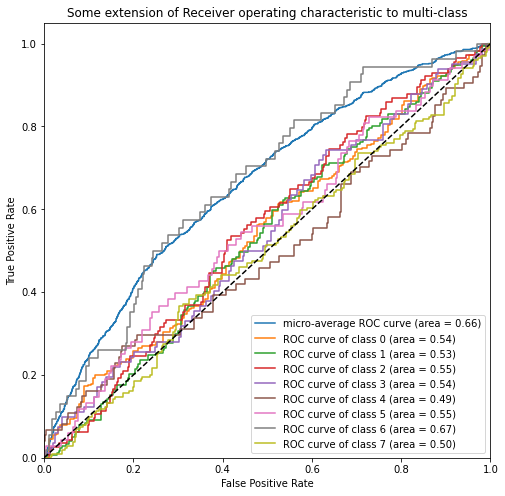

In [56]:
plot_pr_curve(test_labels, predicted_labels_cc.toarray())
plot_roc_curve(test_labels, predicted_labels_cc.toarray())

### Label Powerset
takes correlations into account!

In [57]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(LogisticRegression())
classifier.fit(train_features, train_labels)

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LabelPowerset(classifier=LogisticRegression(), require_dense=[True, True])

In [58]:
predicted_labels_lp = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_lp.toarray())

Accuracy: 0.08523908523908524
Hamming Loss: 0.2765072765072765
Brier Score: 1.5717772621102524
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.69      0.64       290
           1       0.23      0.07      0.11       177
           2       0.15      0.02      0.03       114
           3       0.29      0.02      0.04        82
           4       0.11      0.01      0.02        74
           5       0.00      0.00      0.00        68
           6       1.00      0.02      0.04        54
           7       0.40      0.13      0.20       204

   micro avg       0.50      0.23      0.32      1063
   macro avg       0.35      0.12      0.14      1063
weighted avg       0.37      0.23      0.24      1063
 samples avg       0.62      0.34      0.29      1063

Confusion matrix:
 [[[ 54 137]
  [ 90 200]]

 [[260  44]
  [164  13]]

 [[356  11]
  [112   2]]

 [[394   5]
  [ 80   2]]

 [[399   8]
  [ 73   1]]

 [[411   2]
  [ 68   0]]

 

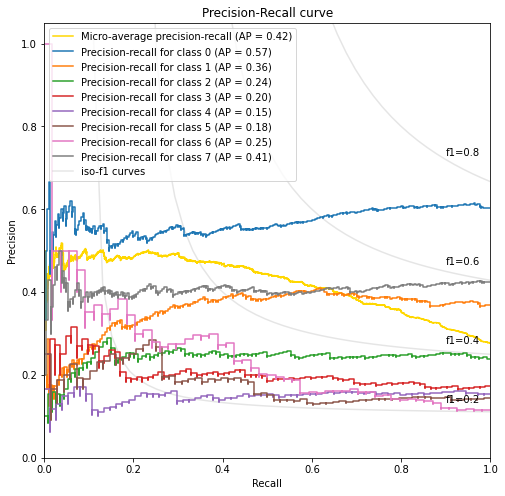

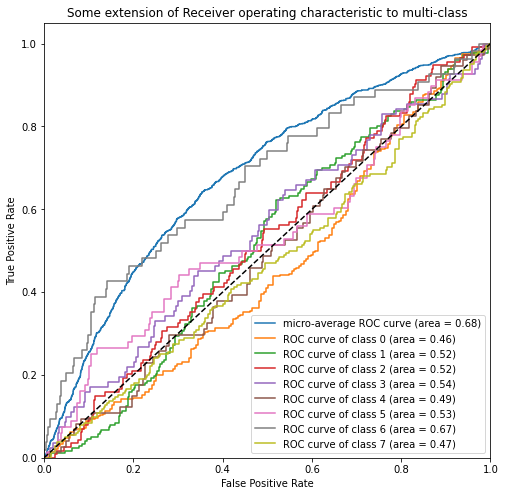

In [59]:
plot_pr_curve(test_labels, predicted_labels_lp.toarray())
plot_roc_curve(test_labels, predicted_labels_lp.toarray())

Accuracy: 0.10810810810810811
Hamming Loss: 0.25
Brier Score: 1.4052727650727652
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.97      0.75       290
           1       1.00      0.01      0.01       177
           2       1.00      0.00      0.00       114
           3       1.00      0.00      0.00        82
           4       1.00      0.00      0.00        74
           5       1.00      0.00      0.00        68
           6       1.00      0.00      0.00        54
           7       0.45      0.02      0.05       204

   micro avg       0.61      0.27      0.37      1063
   macro avg       0.88      0.12      0.10      1063
weighted avg       0.79      0.27      0.21      1063
 samples avg       0.62      0.38      0.36      1063

Confusion matrix:
 [[[ 11 180]
  [  9 281]]

 [[304   0]
  [176   1]]

 [[367   0]
  [114   0]]

 [[399   0]
  [ 82   0]]

 [[407   0]
  [ 74   0]]

 [[413   0]
  [ 68   0]]

 [[427   0]
  [

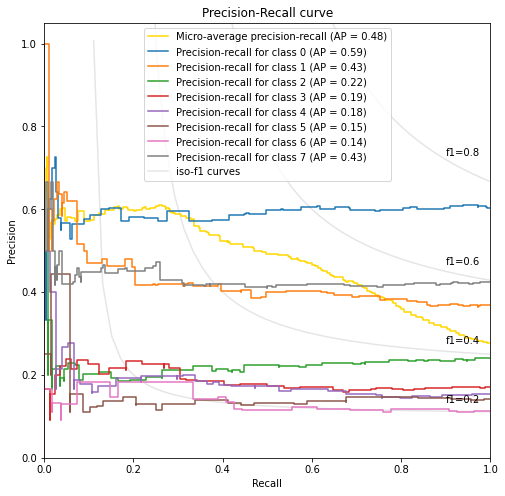

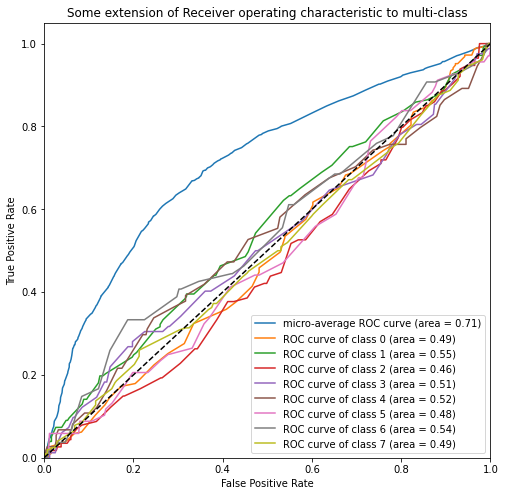

In [60]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(RandomForestClassifier())
classifier.fit(train_features, train_labels)

predicted_labels_lp = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_lp.toarray())

plot_pr_curve(test_labels, predicted_labels_lp.toarray())
plot_roc_curve(test_labels, predicted_labels_lp.toarray())